We hypothesise that there will be two significant peaks in the greyscale intesity of the CT scans, due to edge effects: these will be at the boundary between air and the cementum, and at the cementum-dentine boundary.

To check this we will find 4 random images from 4 teeth, straighten them and plot the greyscale intensity along each row. Hopefully we will see these two peaks.

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
"""
Choose images

"""
import os
import numpy as np

rng = np.random.default_rng(seed=0)

# Pick four numbers for each tooth
n_slices = 4
n_teeth = 3
indices = [
    *rng.integers(0, 108, n_slices),
    *rng.integers(108, 216, n_slices),
    *rng.integers(216, 316, n_slices),
    # *rng.integers(316, 515, 4), Not using this one for now, since the edge detection doesn't work for it
]
assert len(indices) == n_slices * n_teeth

# Find the corresponding filepaths
img_paths = [f"data/original cut/{i:04d}.tif" for i in indices]
mask_paths = [f"data/masks cut/{i:04d}.tif" for i in indices]

for path in img_paths:
    assert os.path.exists(path), path

for path in mask_paths:
    assert os.path.exists(path), path

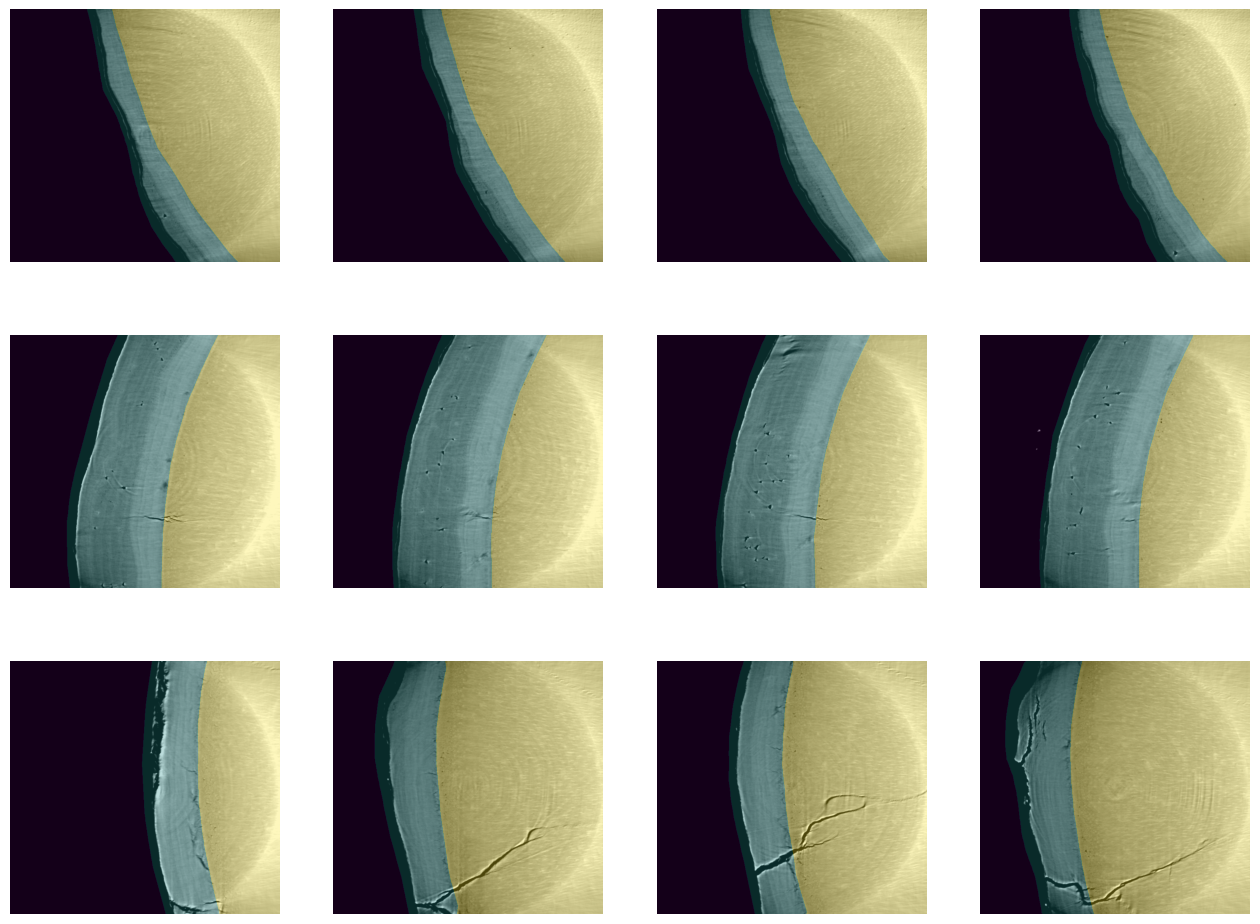

In [12]:
"""
Display them

"""
import matplotlib.pyplot as plt

fig, axes = plt.subplots(n_teeth, n_slices, figsize=(4 * n_slices, 4 * n_teeth))

for axis, img, mask in zip(axes.flat, img_paths, mask_paths):
    axis.imshow(plt.imread(img), cmap="gray")
    axis.imshow(plt.imread(mask), alpha=0.3)

    axis.set_axis_off()

imgdir = "img/detect_cementum"
if not os.path.isdir(imgdir):
    os.mkdir(imgdir)

fig.savefig(f"{imgdir}/img_masks.png", bbox_inches="tight")

  0%|          | 0/12 [00:00<?, ?it/s]

/home/mh19137/cementum/cementum/straighten.py:527: UserWarning: Temporary solution: removing 98 saturated columns from right
  warnings.warn(
/home/mh19137/cementum/cementum/straighten.py:553: UserWarning: Temporary solution: removing 56 zero rows from bottom
  warnings.warn(
  8%|▊         | 1/12 [00:01<00:21,  1.94s/it]/home/mh19137/cementum/cementum/straighten.py:527: UserWarning: Temporary solution: removing 102 saturated columns from right
  warnings.warn(
/home/mh19137/cementum/cementum/straighten.py:553: UserWarning: Temporary solution: removing 59 zero rows from bottom
  warnings.warn(
 17%|█▋        | 2/12 [00:03<00:19,  1.91s/it]/home/mh19137/cementum/cementum/straighten.py:553: UserWarning: Temporary solution: removing 60 zero rows from bottom
  warnings.warn(
 25%|██▌       | 3/12 [00:05<00:17,  1.92s/it]/home/mh19137/cementum/cementum/straighten.py:527: UserWarning: Temporary solution: removing 99 saturated columns from right
  warnings.warn(
/home/mh19137/cementum/cementu

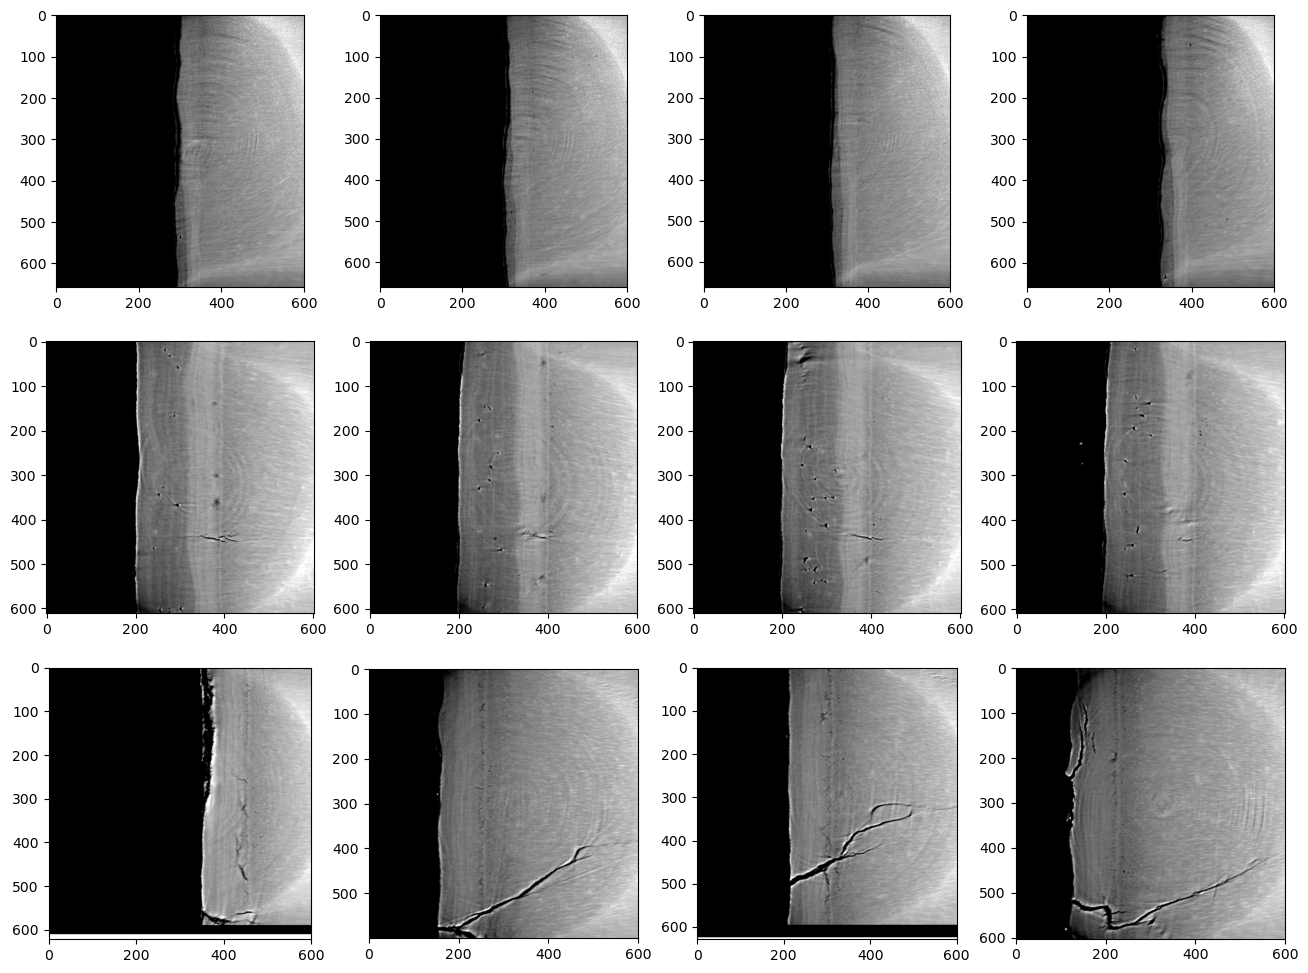

In [13]:
"""
Straighten these images according the the masks

"""
from tqdm import tqdm

from cementum import straighten

n_y = 20
n_left, n_x, n_right = 5, 5, 5

fig, axes = plt.subplots(n_teeth, n_slices, figsize=(4 * n_slices, 4 * n_teeth))

straight_images, straight_masks = [], []

for axis, img_path, mask_path in tqdm(
    zip(axes.flat, img_paths, mask_paths), total=len(img_paths)
):
    # Define two grids of points that will we use to perform our straightening
    mask = plt.imread(mask_path)
    curve_pts = straighten.mask_mesh(mask, n_y, (n_left, n_x, n_right))
    straight_pts = straighten.straight_mesh(mask, n_y, (n_left, n_x, n_right))

    # Straighten the image
    img = plt.imread(img_path)
    straight_image = straighten.apply_transformation(img, curve_pts, straight_pts)

    # Straighten the mask
    straight_mask = straighten.apply_transformation(mask, curve_pts, straight_pts)

    # Remove the white columns from the image and the corresponding columns from the mask
    straight_image, straight_mask = straighten.remove_white_cols(
        straight_image, straight_mask
    )

    # Remove padding
    straight_image = straighten.remove_padding(straight_image)
    straight_mask = straighten.remove_padding(straight_mask)

    straight_images.append(straight_image)
    straight_masks.append(straight_mask)

    # Display it
    axis.imshow(straight_images[-1], cmap="gray")


fig.savefig(f"{imgdir}/straightened.png", bbox_inches="tight")

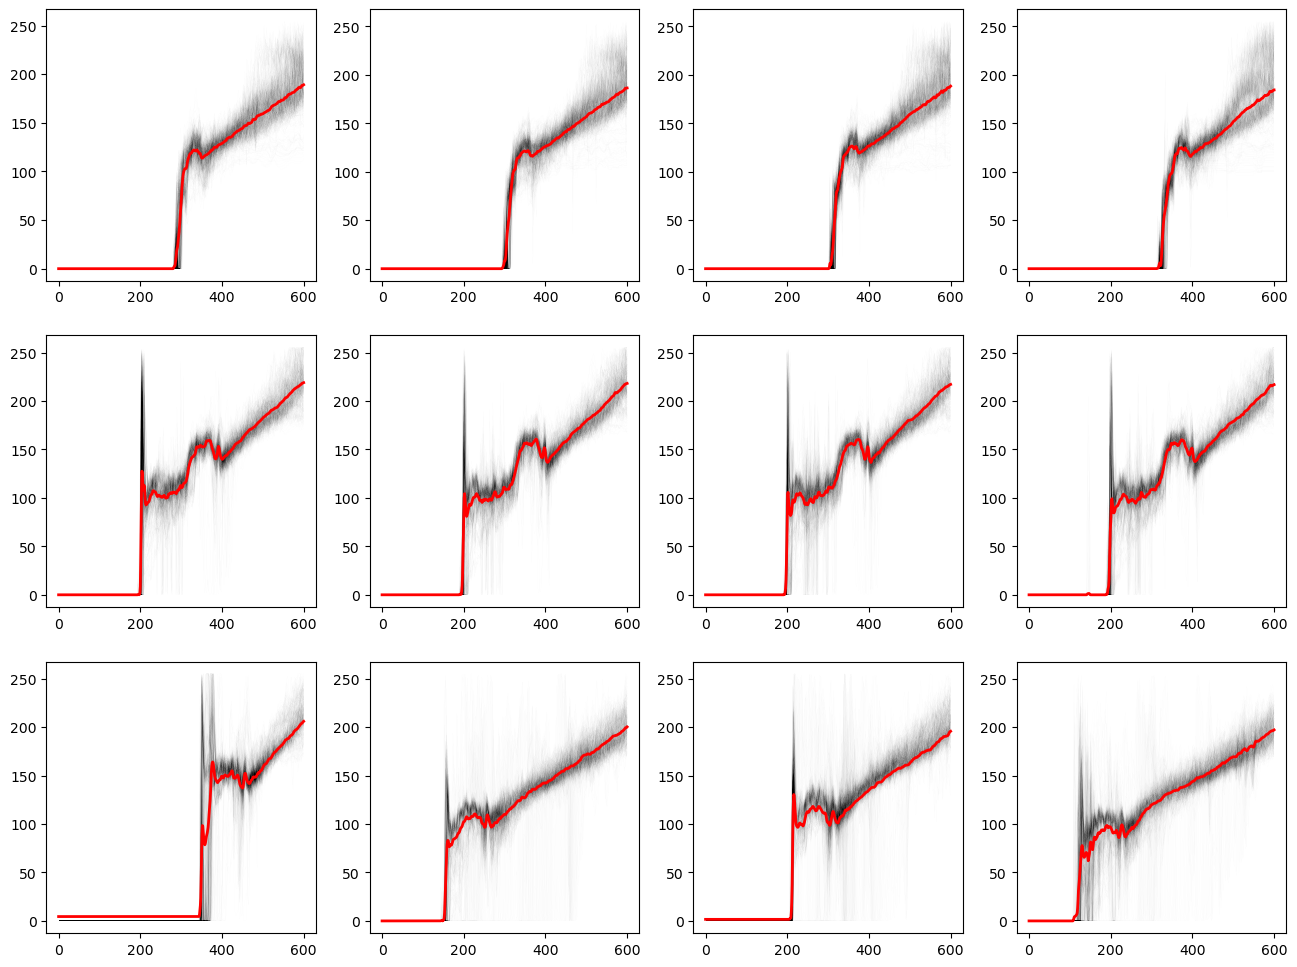

In [14]:
"""
Plot the greyscale intensity across each row for all of these images

"""
fig, axes = plt.subplots(n_teeth, n_slices, figsize=(4 * n_slices, 4 * n_teeth))

for axis, img in zip(axes.flat, straight_images):
    for row in img:
        axis.plot(row, alpha=0.05, linewidth=0.05, color="k")
    axis.plot(np.mean(img, axis=0), color="r", linewidth=2)

fig.savefig(f"{imgdir}/intensities.png", bbox_inches="tight")

In some of the samples, two peaks at the boundaries are very clear - in the first it can't really be seen at all.

As a first attempt, let's try fitting a straight line to the first 100 pixels of the image...

100%|██████████| 12/12 [00:00<00:00, 1079.13it/s]


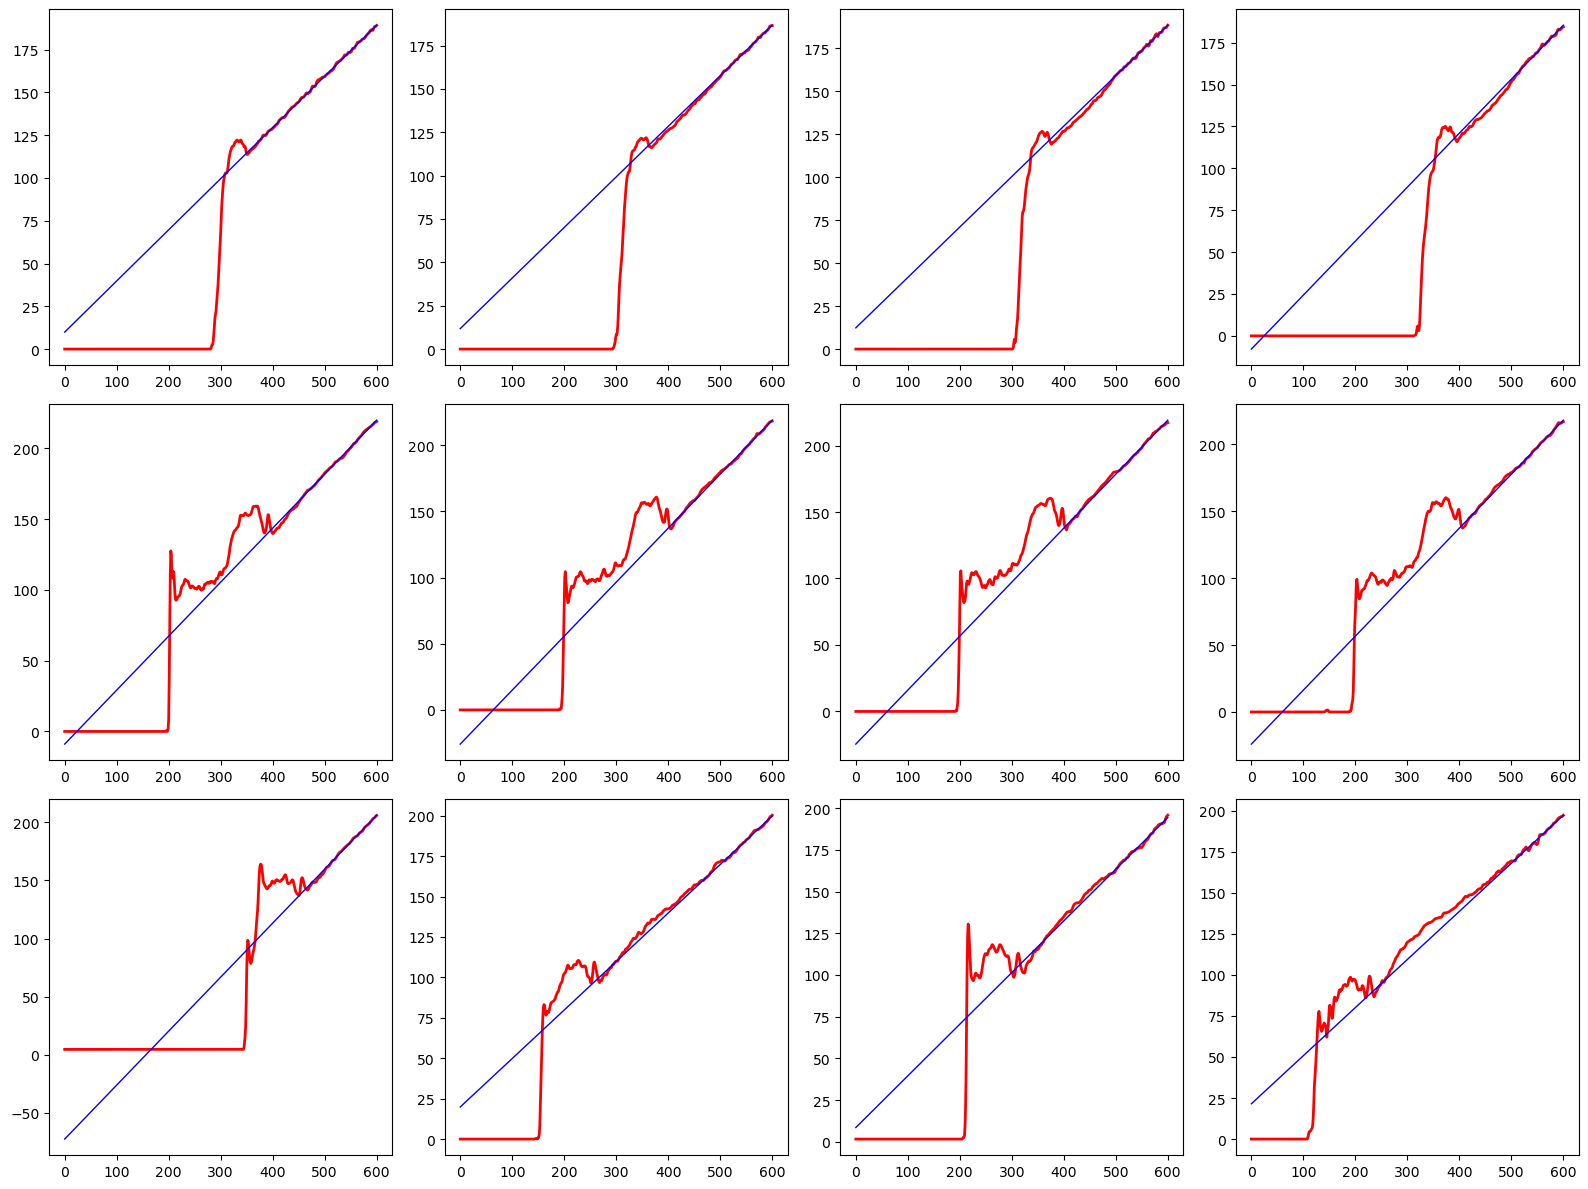

In [15]:
"""
Try to fit the intensity profiles - first fit just to the rightmost 100 pixels

"""
from cementum import fit_cementum

n_pixels = 100

fit_fig, fit_axes = plt.subplots(n_teeth, n_slices, figsize=(4 * n_slices, 4 * n_teeth))

for image, fit_axis in tqdm(
    zip(straight_images, fit_axes.flat), total=len(straight_images)
):
    intensity_profile = np.mean(image, axis=0)
    params, _, _ = fit_cementum.fit_line(n_pixels, intensity_profile)

    x = np.arange(image.shape[1])
    fit_axis.plot(x, intensity_profile, color="r", linewidth=2)
    fit_axis.plot(x, fit_cementum._line(x, *params), color="b", linewidth=1)

fit_fig.tight_layout()
fit_fig.savefig(f"{imgdir}/line_fits.png", bbox_inches="tight")

saving img/detect_cementum/anim/data_original cut_0141.mp4


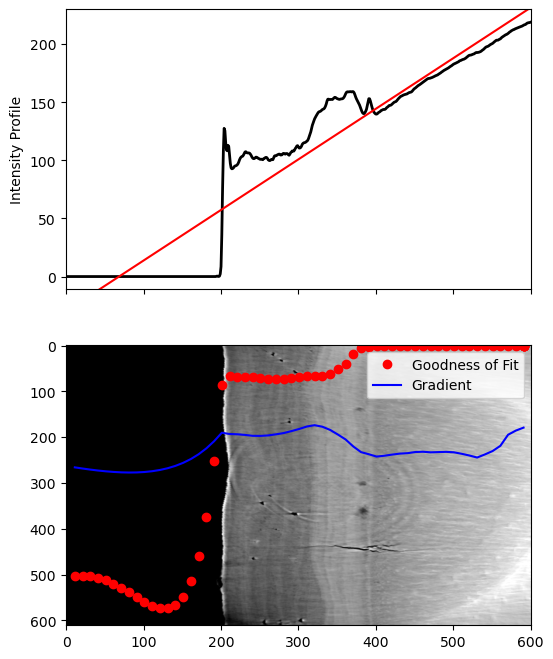

In [16]:
"""
Make a gif

"""
from matplotlib.animation import FuncAnimation

img_index = 4

# Reverse domain sizes since we want to plot the shortest lines first
domain_sizes = np.arange(10, 600, 10)

image = straight_images[img_index]
intensity_profile = np.mean(image, axis=0)

fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

# Show the image and intensity profile
axes[1].imshow(image, cmap="gray", aspect="auto")
axes[0].plot(np.arange(image.shape[1]), intensity_profile, color="k", linewidth=2)

# Do one fit
params, chi2, line_segment = fit_cementum.fit_line(domain_sizes[0], intensity_profile)
fit_starts = []
fit_starts.append(line_segment.min())

gradients = []
gradients.append(params[0] * image.shape[0])

chi2s = [chi2]

# Show the fit
(fit_line,) = axes[0].plot(
    line_segment,
    fit_cementum._line(line_segment, *params),
    "r",
)

# Show the goodness of fit
(chi2_line,) = axes[1].plot(fit_starts, chi2s, "or", label="Goodness of Fit")

# Show the gradient of the line
(gradient_line,) = axes[1].plot(fit_starts, gradients, "-b", label="Gradient")


# Animation
def update_lines(domain_size):
    """
    Perform another fit and update the lines

    """
    params, chi2, line_segment = fit_cementum.fit_line(domain_size, intensity_profile)
    fit_starts.append(line_segment.min())
    chi2s.append(chi2)
    gradients.append(params[0] * image.shape[0])

    fit_line.set_data(line_segment, fit_cementum._line(line_segment, *params))
    chi2_line.set_data(fit_starts, chi2s)
    gradient_line.set_data(fit_starts, gradients)

    return fit_line, chi2_line, gradient_line


anim = FuncAnimation(
    fig,
    update_lines,
    frames=domain_sizes,
    fargs=(),
    interval=100,
    blit=True,
)


axes[0].set_ylabel("Intensity Profile")

axes[1].legend()

anim_dir = f"{imgdir}/anim"
if not os.path.isdir(anim_dir):
    os.mkdir(anim_dir)
path = f"{anim_dir}/{img_paths[img_index].split('.')[0].replace('/', '_')}.mp4"
print(f"saving {path}")
anim.save(path)

100%|██████████| 12/12 [00:07<00:00,  1.68it/s]


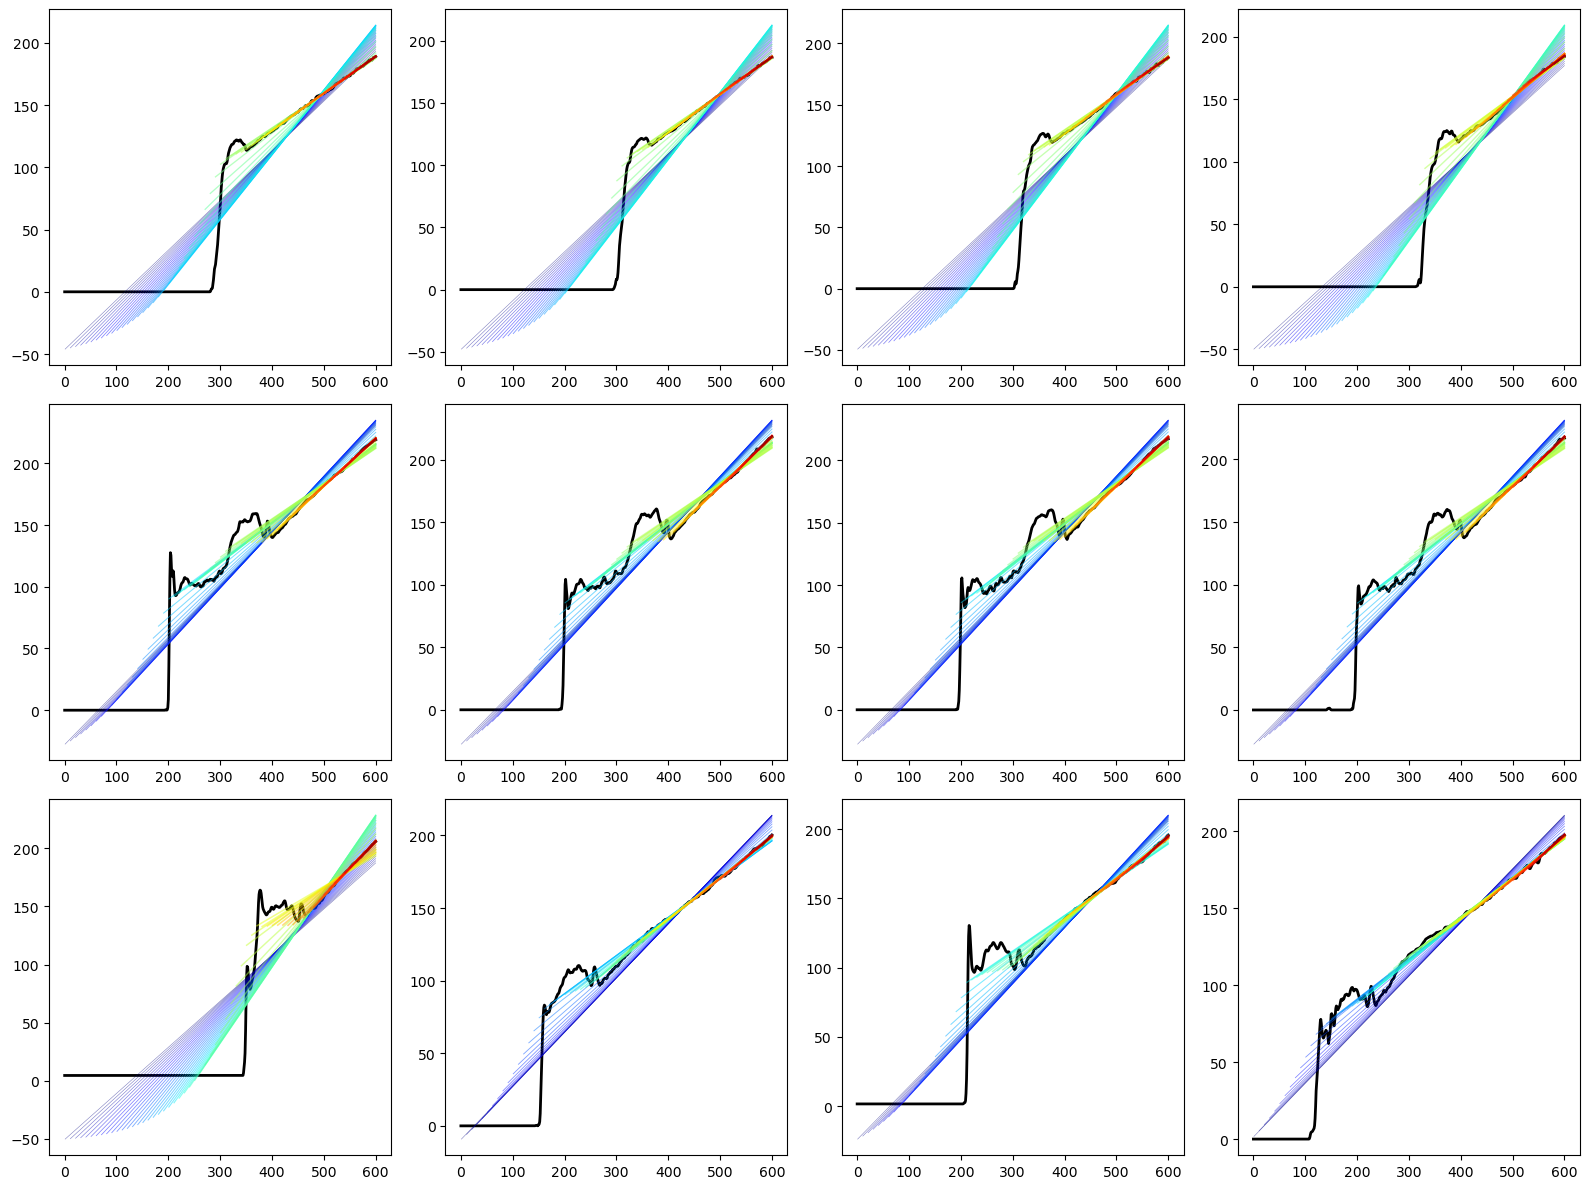

In [17]:
"""
Show lots of these fits

"""
# Plot from longest to shortest so the shortest lines end up on top
domain_sizes = np.arange(600, 10, -10)

# Define colours for our lines
cmap = plt.get_cmap("jet")  # he he
colours = [cmap(i / len(domain_sizes)) for i in range(len(domain_sizes))]

fig, axes = plt.subplots(n_teeth, n_slices, figsize=(4 * n_slices, 4 * n_teeth))

for image, axis in tqdm(
    zip(straight_images, axes.flat),
    total=len(straight_images),
):
    intensity_profile = np.mean(image, axis=0)
    axis.plot(np.arange(image.shape[1]), intensity_profile, color="k", linewidth=2)

    for n_pixels, colour, linewidth in zip(
        domain_sizes, colours, np.linspace(0.4, 1.5, len(domain_sizes))
    ):
        params, _, line_segment = fit_cementum.fit_line(n_pixels, intensity_profile)
        axis.plot(
            line_segment,
            fit_cementum._line(line_segment, *params),
            color=colour,
            linewidth=linewidth,
            alpha=0.5,
        )

    fig.tight_layout()
    fig.savefig(f"{imgdir}/all_line_fits.png", bbox_inches="tight")

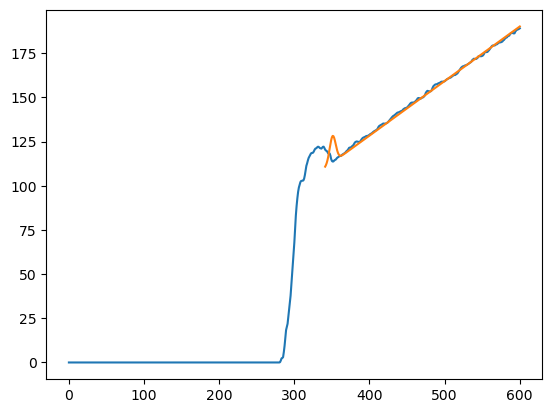

In [18]:
"""
Try doing the fit with a bump

"""
image_index = 0
image = straight_images[image_index]
n_pixels = 260

intensity_profile = np.mean(image, axis=0)

params, _, x_vals = fit_cementum.fit_line_with_bump(n_pixels, intensity_profile)

fig, axis = plt.subplots()

axis.plot(intensity_profile)
axis.plot(x_vals, fit_cementum.line_with_bump(x_vals, *params))

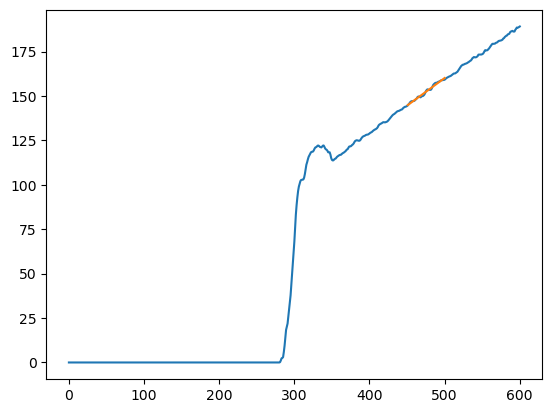

In [25]:
"""
Do the fit with a sliding window

"""
domain_length = 50
offset = 100

intensity_profile = np.mean(image, axis=0)

params, _, x_vals = fit_cementum.fit_line_restricted_domain(
    offset, intensity_profile, n_pixels=domain_length
)

fig, axis = plt.subplots()

axis.plot(intensity_profile)
axis.plot(x_vals, fit_cementum._line(x_vals, *params))

saving img/detect_cementum/anim/data_original cut_0141_restricted.mp4


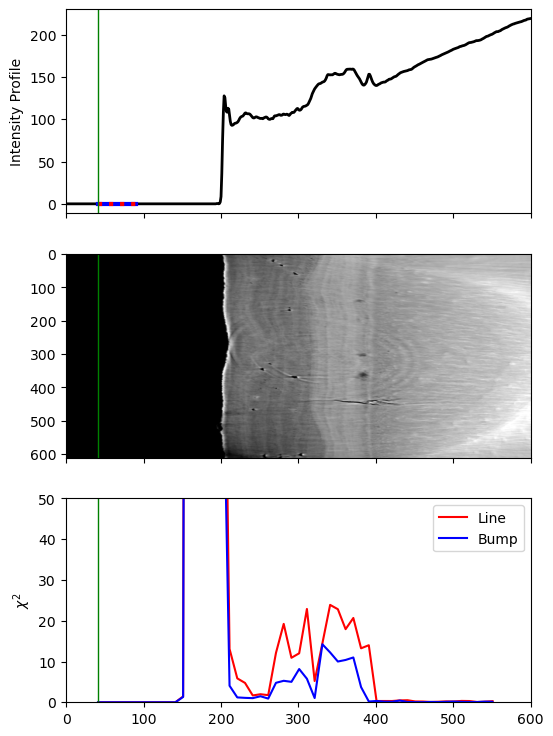

In [78]:
"""
Gif showing the sliding window

"""
img_index = 4
image = straight_images[img_index]

intensity_profile = np.mean(image, axis=0)

fig, axes = plt.subplots(3, 1, figsize=(6, 9), sharex=True)

# Show the intensity profile and image
axes[0].plot(np.arange(image.shape[1]), intensity_profile, color="k", linewidth=2)
axes[1].imshow(image, cmap="gray", aspect="auto")

axes[2].set_ylim((0, 50))

domain_length = 50
offsets = np.arange(0, image.shape[0] - 2 * domain_length, 10)

# Do one fit
line_params, line_chi2, line_x = fit_cementum.fit_line_restricted_domain(
    offsets[0], intensity_profile, n_pixels=domain_length
)
bump_params, bump_chi2, bump_x = fit_cementum.fit_line_with_bump_restricted_domain(
    offsets[0], intensity_profile, n_pixels=domain_length
)

assert (bump_x == line_x).all()
leftmost_points = [line_x.min()]

line_chi2s = [line_chi2]
bump_chi2s = [chi2]

# Show the fits
(bump_line,) = axes[0].plot(
    bump_x,
    fit_cementum.line_with_bump(bump_x, *params),
    "b",
    linewidth=3,
)
(fit_line,) = axes[0].plot(
    line_x,
    fit_cementum.line_with_bump(line_x, *params),
    "r:",
    linewidth=3,
)

# goodness of fits
(line_chi2_line,) = axes[2].plot(leftmost_points, line_chi2s, "-r", label="Line")
(bump_chi2_line,) = axes[2].plot(leftmost_points, bump_chi2s, "-b", label="Bump")

# Vertical lines tracking where we are
vline1 = axes[0].axvline(leftmost_points[-1], color="g", linewidth=1)
vline2 = axes[1].axvline(leftmost_points[-1], color="g", linewidth=1)
vline3 = axes[2].axvline(leftmost_points[-1], color="g", linewidth=1)


# Animation
def update_lines(offset):
    """
    Perform another fit and update the lines

    """
    # Re do fits
    line_params, line_chi2, line_x = fit_cementum.fit_line_restricted_domain(
        offset, intensity_profile, n_pixels=domain_length
    )
    bump_params, bump_chi2, bump_x = fit_cementum.fit_line_with_bump_restricted_domain(
        offset, intensity_profile, n_pixels=domain_length
    )

    # Update fit lines
    assert (line_x == bump_x).all()
    leftmost_points.append(line_x.min())
    fit_line.set_data(line_x, fit_cementum._line(line_x, *line_params))
    bump_line.set_data(bump_x, fit_cementum.line_with_bump(bump_x, *bump_params))

    # Update chi2 lines
    line_chi2s.append(line_chi2)
    bump_chi2s.append(bump_chi2)
    line_chi2_line.set_data(leftmost_points, line_chi2s)
    bump_chi2_line.set_data(leftmost_points, bump_chi2s)

    # Update vertical lines
    vline1.set_data([leftmost_points[-1], leftmost_points[-1]], vline1.get_ydata())
    vline2.set_data([leftmost_points[-1], leftmost_points[-1]], vline2.get_ydata())
    vline3.set_data([leftmost_points[-1], leftmost_points[-1]], vline3.get_ydata())

    return fit_line, bump_line, line_chi2_line, bump_chi2_line


anim = FuncAnimation(
    fig,
    update_lines,
    frames=offsets,
    fargs=(),
    interval=100,
    blit=True,
)


axes[0].set_ylabel("Intensity Profile")

axes[2].legend()
axes[2].set_ylabel(r"$\chi^2$")

anim_dir = f"{imgdir}/anim"
if not os.path.isdir(anim_dir):
    os.mkdir(anim_dir)
path = (
    f"{anim_dir}/{img_paths[img_index].split('.')[0].replace('/', '_')}_restricted.mp4"
)
print(f"saving {path}")
anim.save(path)